## Sarcasm_Headlines

In [23]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, \
    nltk, collections, keras, lightgbm as lgb
from matplotlib import cm
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
import keras.backend as K
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta, Adamax, Nadam
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.utils import plot_model
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/rusconbenito@edu.local/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/rusconbenito@edu.local/nltk_data...


True

In [24]:
df = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)
df['headline'][9]
#df.head()

'lots of parents know this scenario'

In [25]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [26]:
df.drop_duplicates(inplace=True)
df.isna().any()

is_sarcastic    False
headline        False
article_link    False
dtype: bool

In [27]:
#check if dataset is balanced
df["is_sarcastic"].value_counts()

0    14984
1    13633
Name: is_sarcastic, dtype: int64

# Remove Stopwords

In [28]:
stop = stopwords.words('english')
df['headline'] = df['headline'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) #CHTGPT

In [29]:
df['headline'][9]

'lots parents know scenario'

# Stemming

In [30]:
ps = PorterStemmer()
df['headline'] = df['headline'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))

# Lemmetaization

In [31]:
#Lemmetaization of df['headline']
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

df['headline'] = df['headline'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

# Data Exploration

In [32]:
#CHTGPT
df_sarcastic = df[df['is_sarcastic'] == 1]
df_not_sarcastic = df[df['is_sarcastic'] == 0]

# Create a function to generate a word cloud plot
def plot_wordcloud(df_subset, title):
    # Concatenate all the headlines into a single string
    text = " ".join(headline for headline in df_subset['headline'])

    # Generate a word cloud object
    wordcloud = WordCloud(width=800, height=400, max_words=200, background_color="tomato").generate(text)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.savefig('plots/'+ title + '.png')
    plt.show()

# Generate the word cloud plot for sarcastic headlines
plot_wordcloud(df_sarcastic, "Sarcastic Headlines")

# Generate the word cloud plot for non-sarcastic headlines
plot_wordcloud(df_not_sarcastic, "Non-Sarcastic Headlines")


NameError: name 'WordCloud' is not defined

/tmp/ipykernel_680026/74191055.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdBu')


FileNotFoundError: [Errno 2] No such file or directory: 'plots/word_bubbles.png'

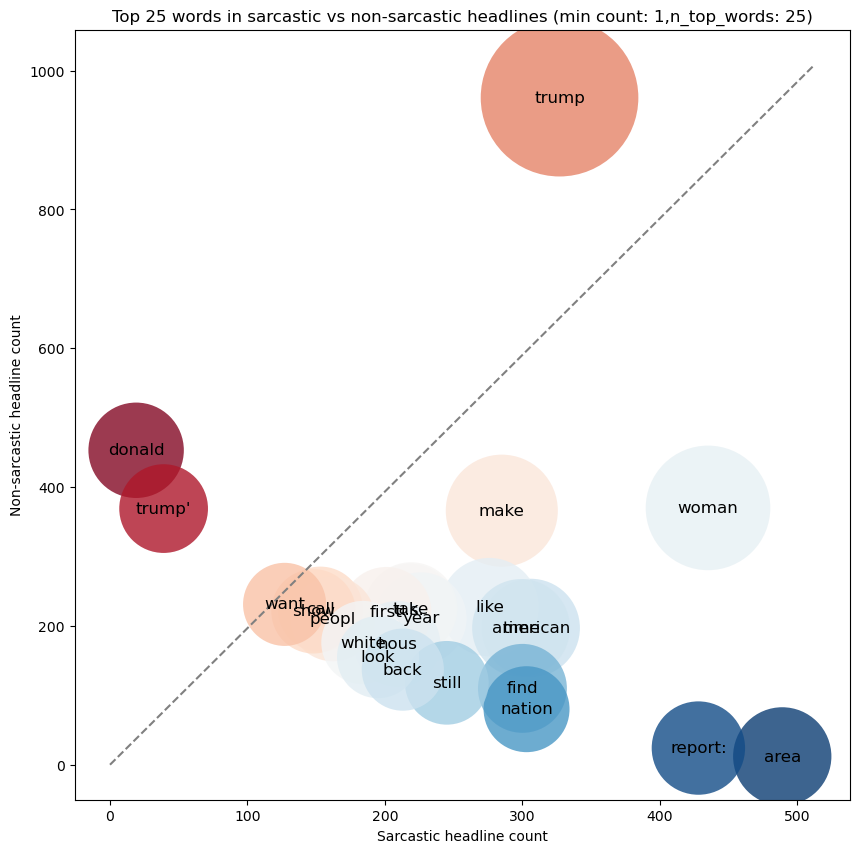

In [33]:
#CHGTPT
min_count = 1
n_top_words = 25

# Count the frequency of each word in sarcastic and non-sarcastic headlines
word_counts = {}
for index, row in df.iterrows():
    for word in row['headline'].split():
        if len(word) > 3:
            if word not in word_counts:
                word_counts[word] = {
                    'count_sarcastic': 0,
                    'count_non_sarcastic': 0,
                    'count_total': 0
                }
            word_counts[word]['count_total'] += 1
            if row['is_sarcastic'] == 1:
                word_counts[word]['count_sarcastic'] += 1
            else:
                word_counts[word]['count_non_sarcastic'] += 1

# Convert the word counts to a DataFrame
df_words = pd.DataFrame.from_dict(word_counts, orient='index')
df_words = df_words[df_words['count_total'] >= min_count]

# Sort the DataFrame by total count
df_words = df_words.sort_values('count_total', ascending=False)

# Select the top n words

df_words = df_words.nlargest(n_top_words, 'count_total')

# Compute the proportion of sarcastic headlines for each word
df_words['prop_sarcastic'] = df_words['count_sarcastic'] / df_words['count_total']

# Define the color map
cmap = cm.get_cmap('RdBu')
colors = cmap(df_words['prop_sarcastic'])

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(
    x=df_words['count_sarcastic'], 
    y=df_words['count_non_sarcastic'], 
    s=df_words['count_total']*10,
    alpha=0.8,
    edgecolors='none',
    c=colors
)

# Add a 45-degree line starting from (0,0)
ax.plot([0, ax.get_xlim()[1]], [0, ax.get_ylim()[1]], ls='--', color='gray')

for index, row in df_words.iterrows():
    ax.annotate(row.name, 
                (row['count_sarcastic'], row['count_non_sarcastic']), 
                fontsize=12, 
                ha='center', 
                va='center')

ax.set_xlabel('Sarcastic headline count')
ax.set_ylabel('Non-sarcastic headline count')

ax.set_title(f'Top {n_top_words} words in sarcastic vs non-sarcastic headlines (min count: {min_count},n_top_words: {n_top_words})')

plt.savefig('plots/word_bubbles.png', dpi=300)
plt.show()



FileNotFoundError: [Errno 2] No such file or directory: 'plots/word_count_hist_1.png'

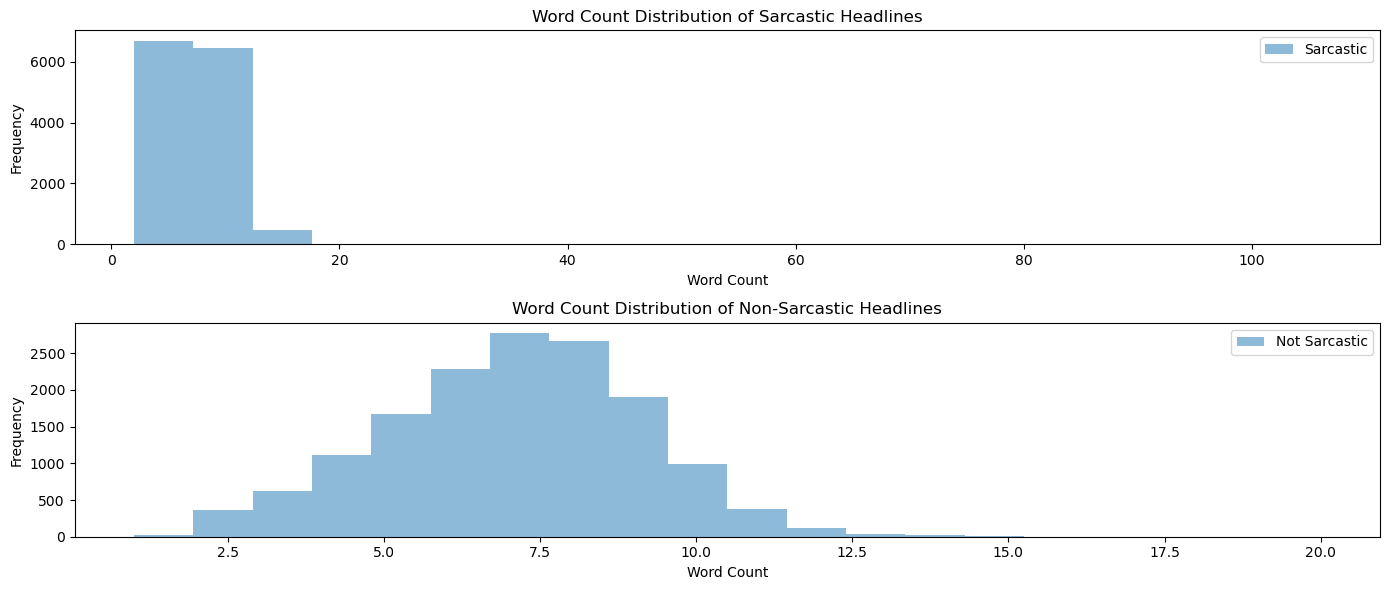

In [34]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 6))
ax[0].hist(df[df['is_sarcastic']==1]['headline'].apply(lambda x: len(x.split())), bins=20, alpha=0.5, label='Sarcastic')
ax[1].hist(df[df['is_sarcastic']==0]['headline'].apply(lambda x: len(x.split())), bins=20, alpha=0.5, label='Not Sarcastic')
ax[0].set_title('Word Count Distribution of Sarcastic Headlines')
ax[1].set_title('Word Count Distribution of Non-Sarcastic Headlines')
ax[0].set_xlabel('Word Count')
ax[1].set_xlabel('Word Count')
ax[0].set_ylabel('Frequency')
ax[1].set_ylabel('Frequency')
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.savefig('plots/word_count_hist_1.png', dpi=300)
plt.show()

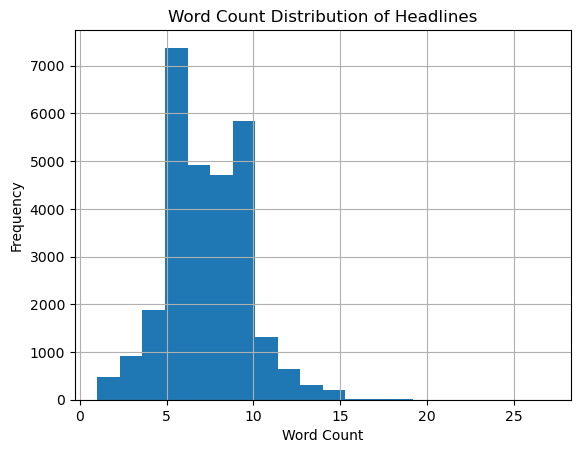

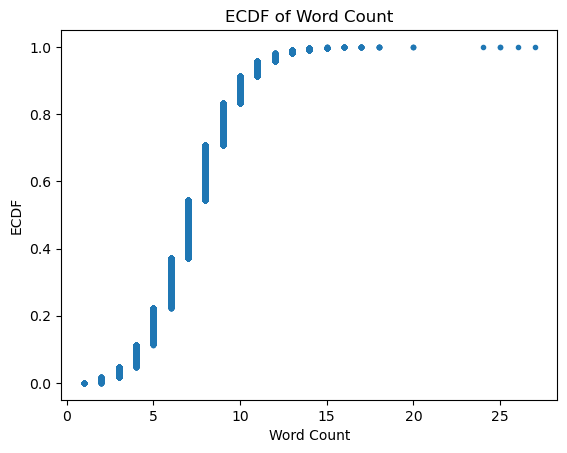

In [35]:
# Give column with max len
df['headline'].apply(lambda x: len(x.split())).idxmax()

# print the max len headline
df['headline'][df['headline'].apply(lambda x: len(x.split())).idxmax()]

# remove the max len headline column
df.drop(df['headline'].apply(lambda x: len(x.split())).idxmax(), inplace=True)

# histogram of len of headlines
df['headline'].apply(lambda x: len(x.split())).hist(bins=20)
plt.title('Word Count Distribution of Headlines')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.savefig('plots/word_count_hist_2.png', dpi=300)
plt.show()


# ecdf diagram of length of headlines
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

# Compute ECDF for word count
x, y = ecdf(df['headline'].apply(lambda x: len(x.split())))
plt.plot(x, y, marker='.', linestyle='none')
plt.xlabel('Word Count')
plt.ylabel('ECDF')
plt.title('ECDF of Word Count')
plt.savefig('plots/word_count_ecdf.png', dpi=300)
plt.show()

